In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import signal
import scipy.stats as scs
%matplotlib inline

/Applications/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### The bitcoin dollar price data was downloaded from Quandl.  I chose the set from the Bitstamp Exchange

In [2]:
df2 = pd.read_csv('data/bitstamp.txt', sep='\t')

In [3]:
df2.set_index(pd.DatetimeIndex(df2['Timestamp']), inplace=True, drop=True)

In [4]:
del df2['Timestamp']

In [5]:
df2.head(2)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2014-02-16,655.83,670,590.01,621,26397.57,16510289.03,625.45
2014-02-17,621,664.99,610,633.66,19902.44,12681178.75,637.17


In [7]:
# Change to numeric data
df2['Open'] = pd.to_numeric(df2['Open'], errors='coerce')
df2['High'] = pd.to_numeric(df2['High'], errors='coerce')
df2['Low'] = pd.to_numeric(df2['Low'], errors='coerce')
df2['Close'] = pd.to_numeric(df2['Close'], errors='coerce')
df2['Volume (BTC)'] = pd.to_numeric(df2['Volume (BTC)'], errors='coerce')
df2['Volume (Currency)'] = pd.to_numeric(df2['Volume (Currency)'], errors='coerce')
df2['Weighted Price'] = pd.to_numeric(df2['Weighted Price'], errors='coerce')

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1460 entries, 2014-02-16 to 2018-02-14
Data columns (total 7 columns):
Open                 1457 non-null float64
High                 1457 non-null float64
Low                  1457 non-null float64
Close                1457 non-null float64
Volume (BTC)         1457 non-null float64
Volume (Currency)    1457 non-null float64
Weighted Price       1457 non-null float64
dtypes: float64(7)
memory usage: 91.2 KB


### Resampled Data for weekly average - used Weighted Price

In [9]:
# Resampled to get weekly mean of 'weighted price'
weekly_bit = df2['Weighted Price'].resample('W').mean()

In [11]:
### Plotting weekly price, differenced data, log-transformed data, and differenced log-transformed data

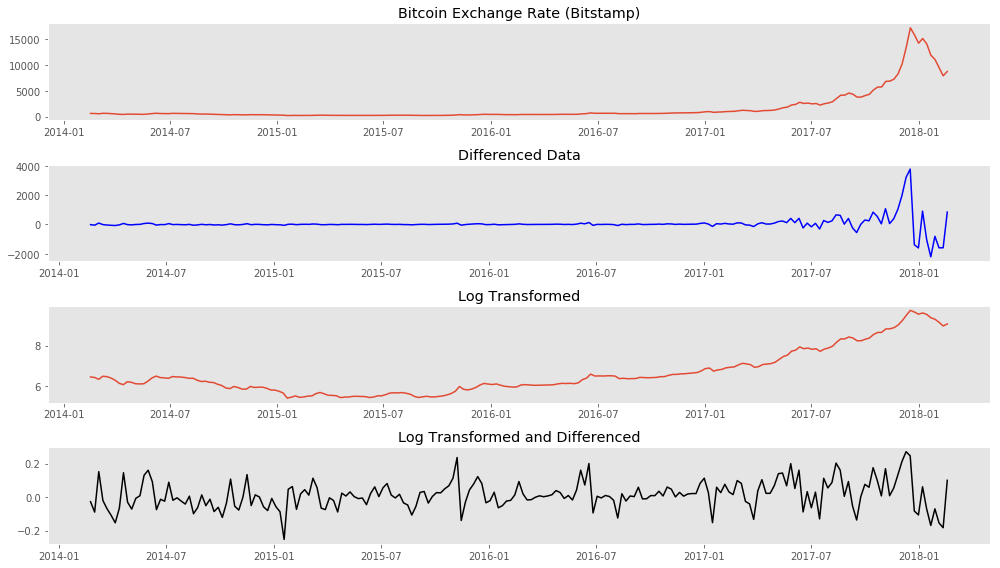

In [14]:
plt.style.use('ggplot')
fig, ax = plt.subplots(4, 1, figsize=(14, 8))
ax[0].plot(weekly_bit.index, weekly_bit)
ax[0].set_title('Bitcoin Exchange Rate (Bitstamp)')
ax[0].grid(False)
ax[1].plot(weekly_bit.index, weekly_bit.diff(), color='b')
ax[1].set_title('Differenced Data')
ax[1].grid(False)
ax[2].plot(weekly_bit.index, np.log(weekly_bit))
ax[2].set_title('Log Transformed')
ax[2].grid(False)
ax[3].plot(weekly_bit.index, np.log(weekly_bit).diff(), color='k')
ax[3].set_title('Log Transformed and Differenced')
ax[3].grid(False)
# ax.set_title('Philippine Peso Weekly Exchange Rate')
plt.tight_layout()
# plt.savefig('data/bitcoin_transformation.png')

#### Log transformation and differencing appear to have made the time series stationary. 
#### ADFuller test for stationarity confirms this.

In [15]:
untransformed = sm.tsa.stattools.adfuller(weekly_bit)
diffed_week = sm.tsa.stattools.adfuller(weekly_bit.diff()[1:])
logged_week = sm.tsa.stattools.adfuller(np.log(weekly_bit))
log_diff_week = sm.tsa.stattools.adfuller(np.log(weekly_bit).diff()[1:])
log_diff2 = sm.tsa.stattools.adfuller(np.log(weekly_bit).diff(2)[2:])

In [16]:
print 'ADFuller Test for Stationarity'
print 'Untransformed Series {}'.format(untransformed[1])
print 'Differenced (1) {}'.format(diffed_week[1]) 
print 'Log Transformation {}'.format(logged_week[1])
print 'Log Transformation and Differencing(1) {}'.format(log_diff_week[1])
print 'Log Transformation and Differencing(2) {}'.format(log_diff2[1])

ADFuller Test for Stationarity
Untransformed Series 1.0
Differenced (1) 0.741516170524
Log Transformation 0.994334841317
Log Transformation and Differencing(1) 3.01872830745e-18
Log Transformation and Differencing(2) 2.07801212847e-05


In [17]:
# the differenced log-transformed data had the lowest ADFuller score
log_weekly_bit = np.log(weekly_bit)

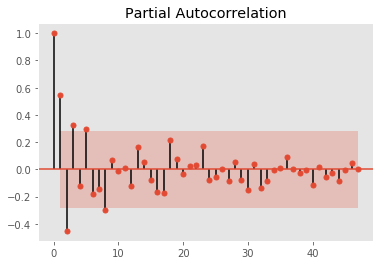

In [19]:
plot_pacf(log_weekly_bit.diff(2)[2:50])
plt.grid(False)
# plt.savefig('data/bitcoin_pacf.png')

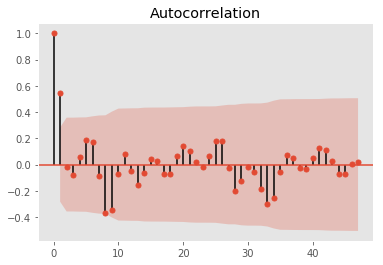

In [20]:
plot_acf(log_weekly_bit.diff(2)[2:50])
plt.grid(False)
plt.savefig('data/bitcoin_acf.png')

### Autocorrelation and partial autocorrelation plots suggests an optimal AR(2) and MA(1) is sufficient with differencing of 1
### Also performed a training and testing set split of the data. Trained on the first 85% and will validate on the remaining 15% of the series. 
### However,  optimization runs showed that when the (p,d,q) values of (1,2,1) was used we obtained the lowest AIC, BIC scores and best p-values for coeffs

                             ARIMA Model Results                              
Dep. Variable:      D2.Weighted Price   No. Observations:                  176
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 218.904
Method:                       css-mle   S.D. of innovations              0.069
Date:                Thu, 01 Mar 2018   AIC                           -429.807
Time:                        23:56:20   BIC                           -417.125
Sample:                    03-02-2014   HQIC                          -424.664
                         - 07-09-2017                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0004      0.000      2.930      0.004       0.000       0.001
ar.L1.D2.Weighted Price     0.1818      0.074      2.447      0.015       0.036       0.327


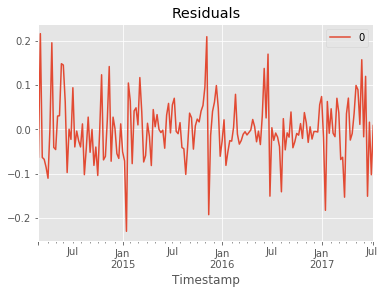

                0
count  176.000000
mean    -0.000787
std      0.070537
min     -0.230235
25%     -0.040174
50%     -0.004960
75%      0.035439
max      0.216069


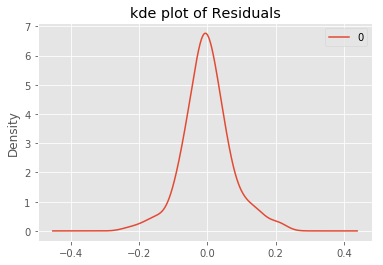

In [23]:

idx3 = int(len(log_weekly_bit) * 0.85)
train3 = log_weekly_bit[:idx3]
test3 = log_weekly_bit[idx3:]
model3 = ARIMA(train3, order=(1,2,1))
model_fit3 = model3.fit(disp=0)
print(model_fit3.summary())
# plot residual errors
residuals3 = pd.DataFrame(model_fit3.resid)
residuals3.plot()
plt.title('Residuals')
plt.show()
residuals3.plot(kind='kde')
plt.title('kde plot of Residuals')
# pyplot.show()
print(residuals3.describe())

In [24]:
from sklearn.metrics import mean_squared_error

In [27]:
""" Setting arrays for true values in the test set and predicted/forecast values from the model """
truth = test3.head(32).values
forecast = (model_fit3.forecast(steps=32))
pred = forecast[0]

In [28]:
rmse = np.sqrt(mean_squared_error(truth, pred))
print 'Root MSE {}'.format(rmse)

Root MSE 0.353034310708


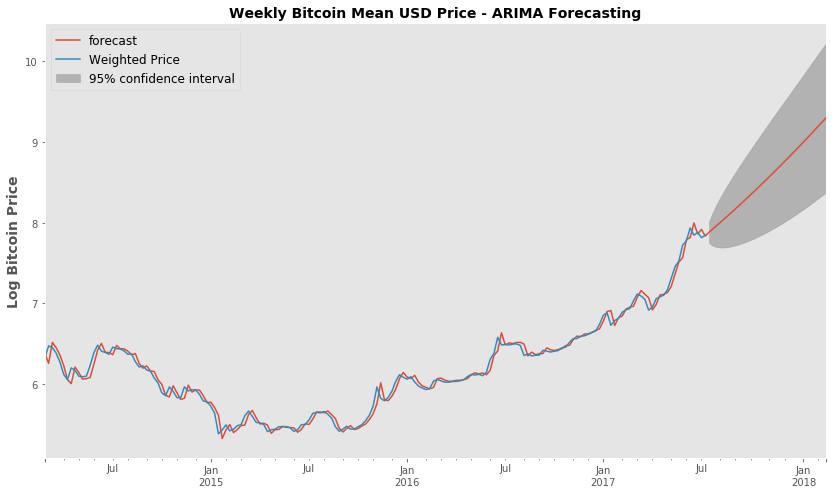

In [31]:
fig, ax = plt.subplots(figsize=(14,8))
fig = model_fit3.plot_predict(start='2014-03-02', end='2018-02-18', ax=ax)
legend = ax.legend(loc='upper left', fontsize='large')
ax.set_ylabel('Log Bitcoin Price',fontsize=14, fontweight='bold')
ax.set_title('Weekly Bitcoin Mean USD Price - ARIMA Forecasting', fontsize=14, fontweight='bold' )
ax.grid(False)
# plt.savefig('data/confidence.png')

### Using the ARIMA forecast function - Looking at how the forecast price (untransformed) compares to the truth

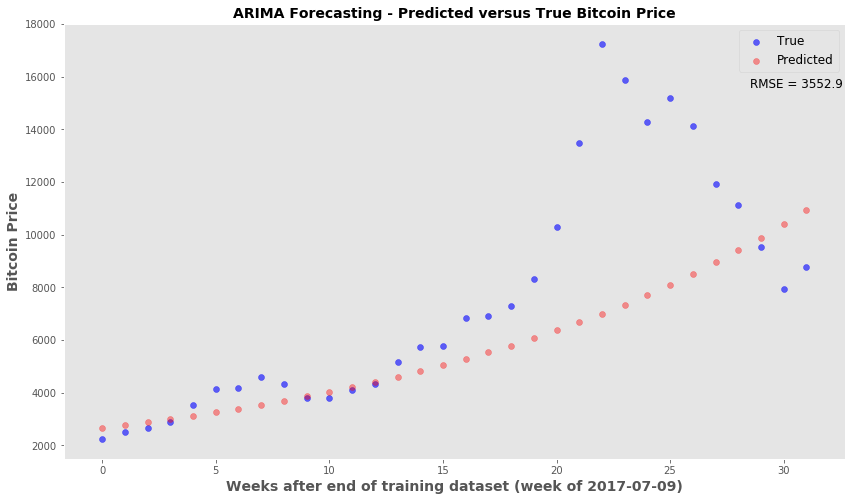

In [36]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,8))
x_val = range(len(truth))
ax.scatter(x_val, np.exp(truth), c='blue', label='True', alpha=0.6)
ax.scatter(x_val, np.exp(pred), c='red', alpha=0.4, label='Predicted')
ax.set_xlabel('Weeks after end of training dataset (week of 2017-07-09)', fontsize=14, fontweight='bold')
ax.set_ylabel('Bitcoin Price', fontsize=14, fontweight='bold')
ax.legend(fontsize='large', markerscale=1)
ax.grid(False)
ax.set_title('ARIMA Forecasting - Predicted versus True Bitcoin Price', fontsize=14, fontweight='bold' )
ax.text(28.5, 15600, 'RMSE = 3552.9', fontsize=12)
# plt.savefig('data/forecasting.png')

### Stepwise Forecasting/Retraining ARIMA model
* The idea is that most accurate predictions occur in the first few time points past the training set
* This snippet will forecast only to the next time point
* Afterwards, the true price for that time point is added back to the series and the ARIMA model is retrained.
* The retrained model will then forecast the following time point and the retraining is performed again after every forecasting step.

In [33]:
from collections import deque
moving = list(train3)
mov_test = deque(test3)
pred_steps =[]
for n in range(len(test3)):
    model = ARIMA(moving, order=(1,2,1))
    model_fit = model.fit(disp=0)
    forecast_one = model_fit.forecast(steps=1) # forecast the next time point only
    pred_steps.append(forecast_one[0])
    z = mov_test.popleft()
    moving.append(z) #update the training data with next time point

/Applications/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Applications/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/ana

In [34]:
#rmse of stepwise 
np.sqrt(mean_squared_error(np.exp(test3), np.exp(pred_steps)))

1252.7893334584987

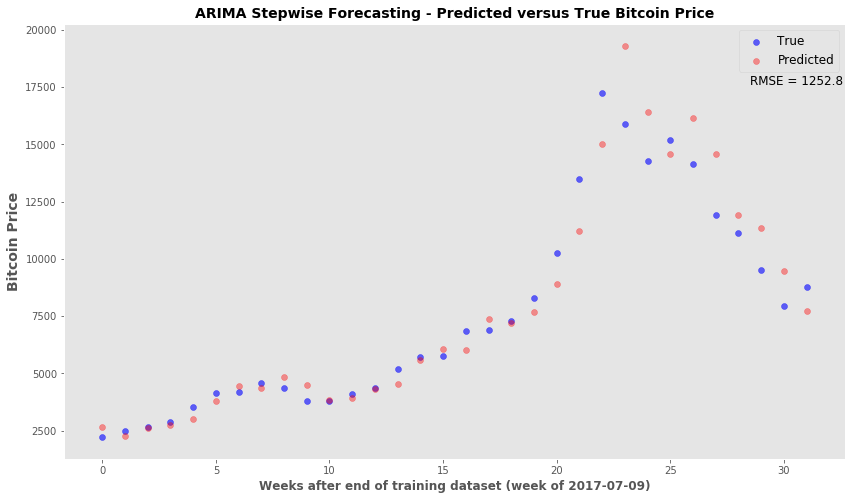

In [35]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,8))
x_val = range(len(test3))
ax.scatter(x_val, np.exp(test3), c='blue', label='True', alpha=0.6)
ax.scatter(x_val, np.exp(pred_steps), c='red', alpha=0.4, label='Predicted')
ax.set_xlabel('Weeks after end of training dataset (week of 2017-07-09)', fontsize=12, fontweight='bold')
ax.set_ylabel('Bitcoin Price', fontsize=14, fontweight='bold')
ax.legend(fontsize='large', markerscale=1)
ax.grid(False)
ax.set_title('ARIMA Stepwise Forecasting - Predicted versus True Bitcoin Price', fontsize=14, fontweight='bold' )
ax.text(28.5, 17600, 'RMSE = 1252.8', fontsize=12)
# plt.savefig('data/forecasting_stepwise.png')

### Conclusion - ARIMA time series modeling can provide a decent forecasting tool. If the forecasting algorithm is set up so that the model can be continually updated, then the forecasts for the immediate time points are acceptable.  I will revisit this time series model with unseen new data. This particular time series ended in mid-February 2018 and I will wait a few weeks to do the two forecasting analysis again.